In [112]:
#**** Sentiment Analysis using Dutch Tweets****
# by SELIM SAMETOGLU
# This is a secondary version where I try to implement pipelines from scikitlearn


## Load dependencies

In [113]:
# load the dependencies
# Utility
import pandas as pd
import numpy as np
import re
# Prepro
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
# Plotting
from matplotlib import pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
# sklearn
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
# Has to be installed at each runtime
# ! pip install langdetect
# to connect to drive
# from google.colab import drive
# drive.mount('/content/drive')

In [114]:
# Load the dataset
data = pd.read_json("/content/drive/MyDrive/Collab_data/dutch_tweets_chunk0.json")

In [115]:
# Check the lenght of the data
# print('number of messages:', len(data))
# data[["sentiment_pattern"]].hist()
# data[["sentiment_pattern"]]

number of messages: 27019


array([[<Axes: title={'center': 'sentiment_pattern'}>]], dtype=object)

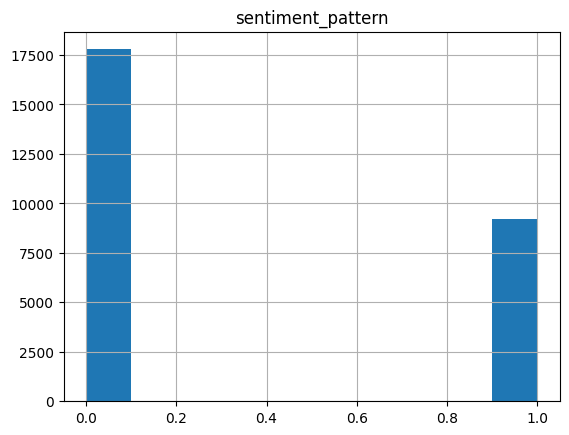

In [118]:
# dichotimize the sentiment categories
data.loc[data["sentiment_pattern"] <0, "sentiment_pattern"] = 0
data.loc[data["sentiment_pattern"] >0, "sentiment_pattern"] = 1
# check with a histogram whether it worked
data[["sentiment_pattern"]].hist()


In [119]:
# take only a small portion of the data for better speed
data = data[:1500]

# Using Custom Transformers and Scikit pipelines for preprocessing

### step 1: Create a custom transformer for filtering out 'Non-Dutch' sentences

In [ ]:
#  Creating a preprocessing step with
from sklearn.base import BaseEstimator, TransformerMixin
from langdetect import detect

class LanguageFilter(BaseEstimator, TransformerMixin):
  def __init__(self):
    pass

# filter out non-Dutch sentences
  def detect_language(self, X, y=None):
    try:
        return detect(X)
    except:
        return 'unknown'

  def fit(self, X, y = None):
    return self

  def transform(self, X, y= None):
    X['language'] = X['full_text'].apply(self.detect_language)
    X = X[X['language'] == 'nl']
    X.drop('language', axis = 1, inplace = True)
    return X

In [ ]:
# call the class
language_filter = LanguageFilter()
# and apply via fit_transform on the data
language_filter.fit_transform(data)

In [120]:
# STEP 1: version prior to custom transformers:
# from langdetect import detect
# def detect_language(text):
#    try:
#        return detect(text)
#    except:
#        return 'unknown'
# data['language']=data['full_text'].apply(detect_language)
# data = data[data['language'] == 'nl']
# data.drop('language', axis = 1, inplace = True)

<ipython-input-120-258bc7113f79>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.drop('language', axis = 1, inplace = True)


### step 2: column manipulations and turning 'statements into lower case'

In [122]:
# STEP 2: take only the full text and the labels
data = data[["full_text", "sentiment_pattern"]]
# change the column names
data.columns = ["text", "label"]

# and check null values, should be 0
# np.sum(data.isnull().any(axis=1))

# make the statement text in lowercase
data['text']=data['text'].str.lower()
data['text'].tail() # check

In [130]:
# STEP 3: clean and remove the stopwords from the text
# define the DUTCH stopwordlist
stopwordlist = ['aan','al','alles','als', 'altijd','andere', 'ben','bij',
'daar','dan','dat','de','der','deze','die','dit','doch','doen','door','dus',
'een','eens','en','er','ge','geen','geweest','haar','had','heb','hebben','heeft',
'hem','het','hier','hij','hoe','hun','iemand','iets','ik','in','is','ja',
'je','kan','kon','kunnen','maar','me','meer','men','met','mij','mijn','moet',
'na','naar','niet','niets','nog','nu','of','om','omdat','onder','ons','ook',
'op','reeds','te','tegen','toch','toen','tot','u','uit','uw','van','veel','voor',
'want','waren','was','wat','werd','wezen','wie','wil','worden','wordt','zal',
'ze','zelf','zich','zij','zijn','zo','zonder','zou']

STOPWORDS = set(stopwordlist)
def cleaning_stopwords(text):
    return " ".join([word for word in str(text).split() if word not in STOPWORDS])

data['text'] = data['text'].apply(lambda text: cleaning_stopwords(text))
data['text'].head() # check

2    rt @ddstandaard: droom d66 werkelijkheid: covi...
3    rt @ddstandaard: droom d66 werkelijkheid: covi...
4    droom d66 werkelijkheid: covid-19 superdodelij...
5    droom d66 werkelijkheid: covid-19 superdodelij...
9    rt @frankvanwijck: aantal deskundigen corona g...
Name: text, dtype: object

In [131]:
# STEP 4: clean and remove the punctuations
import string
english_punctuations = string.punctuation
punctuations_list = english_punctuations
def cleaning_punctuations(text):
    translator = str.maketrans('', '', punctuations_list)
    return text.translate(translator)
data['text']= data['text'].apply(lambda x: cleaning_punctuations(x))
data['text'].tail() # check

1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1498    rt moorkopje2 jodelieho dom antwoord weet wel ...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [132]:
# STEP 5: clean and remove repeating characters
def cleaning_repeating_char(text):
    return re.sub(r'(.)1+', r'1', text)
data['text'] = data['text'].apply(lambda x: cleaning_repeating_char(x))
data['text'].tail() # check

1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1498    rt moorkopje2 jodelieho dom antwoord weet wel ...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [133]:
# STEP 6: clean and remove URLs
def cleaning_URLs(dataset):
    return re.sub('((www.[^s]+)|(https?://[^s]+))',' ', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_URLs(x))
data['text'].tail() #check

1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1498    rt moorkopje2 jodelieho dom antwoord weet wel ...
1499            rt sbp99 ga liegen lockdown wel voordelen
Name: text, dtype: object

In [134]:
# STEP 7: clean and remove numbers
def cleaning_numbers(dataset):
    return re.sub('[0-9]+', '', dataset)
data['text'] = data['text'].apply(lambda x: cleaning_numbers(x))
data['text'].tail() #check

1494    waalse psminister “belgië gecompliceerd land p...
1495    corona drenthe groningen  jacht mondkapjes gaa...
1496    rt bosm jaap dissel rivm ook nieuw onderzoek s...
1498    rt moorkopje jodelieho dom antwoord weet wel v...
1499              rt sbp ga liegen lockdown wel voordelen
Name: text, dtype: object

In [136]:
# STEP 8: tokenization
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()
data['text'] = data['text'].apply(tokenizer.tokenize)
data['text']

2       [rt, ddstandaard, droom, d, werkelijkheid, cov...
3       [rt, ddstandaard, droom, d, werkelijkheid, cov...
4       [droom, d, werkelijkheid, covi, superdodelijk,...
5       [droom, d, werkelijkheid, covi, superdodelijk,...
9       [rt, frankvanwijck, aantal, deskundigen, coron...
                              ...                        
1494    [waalse, psminister, “belgië, gecompliceerd, l...
1495    [corona, drenthe, groningen, jacht, mondkapjes...
1496    [rt, bosm, jaap, dissel, rivm, ook, nieuw, ond...
1498    [rt, moorkopje, jodelieho, dom, antwoord, weet...
1499      [rt, sbp, ga, liegen, lockdown, wel, voordelen]
Name: text, Length: 1181, dtype: object

In [137]:
# STEP 9: stemming
from nltk.stem.snowball import DutchStemmer

st = DutchStemmer()
def stemming_on_text(dataset):
    text = [st.stem(word) for word in dataset]
    return dataset
data['text']= data['text'].apply(lambda x: stemming_on_text(x))
data['text'].head()

2    [rt, ddstandaard, droom, d, werkelijkheid, cov...
3    [rt, ddstandaard, droom, d, werkelijkheid, cov...
4    [droom, d, werkelijkheid, covi, superdodelijk,...
5    [droom, d, werkelijkheid, covi, superdodelijk,...
9    [rt, frankvanwijck, aantal, deskundigen, coron...
Name: text, dtype: object

In [138]:
# create the 'X' with the features, and create the'y' with the annotations/sentiment
X = data['text']
y = data['label']


## WordClouds

In [139]:
# Categorize data as positive and negative
data_pos = data.loc[data['label'] == 1]
data_neg = data.loc[data['label'] == 0]
data_pos = data_pos['text']
data_neg = data_neg['text']

### Word cloud for negative words

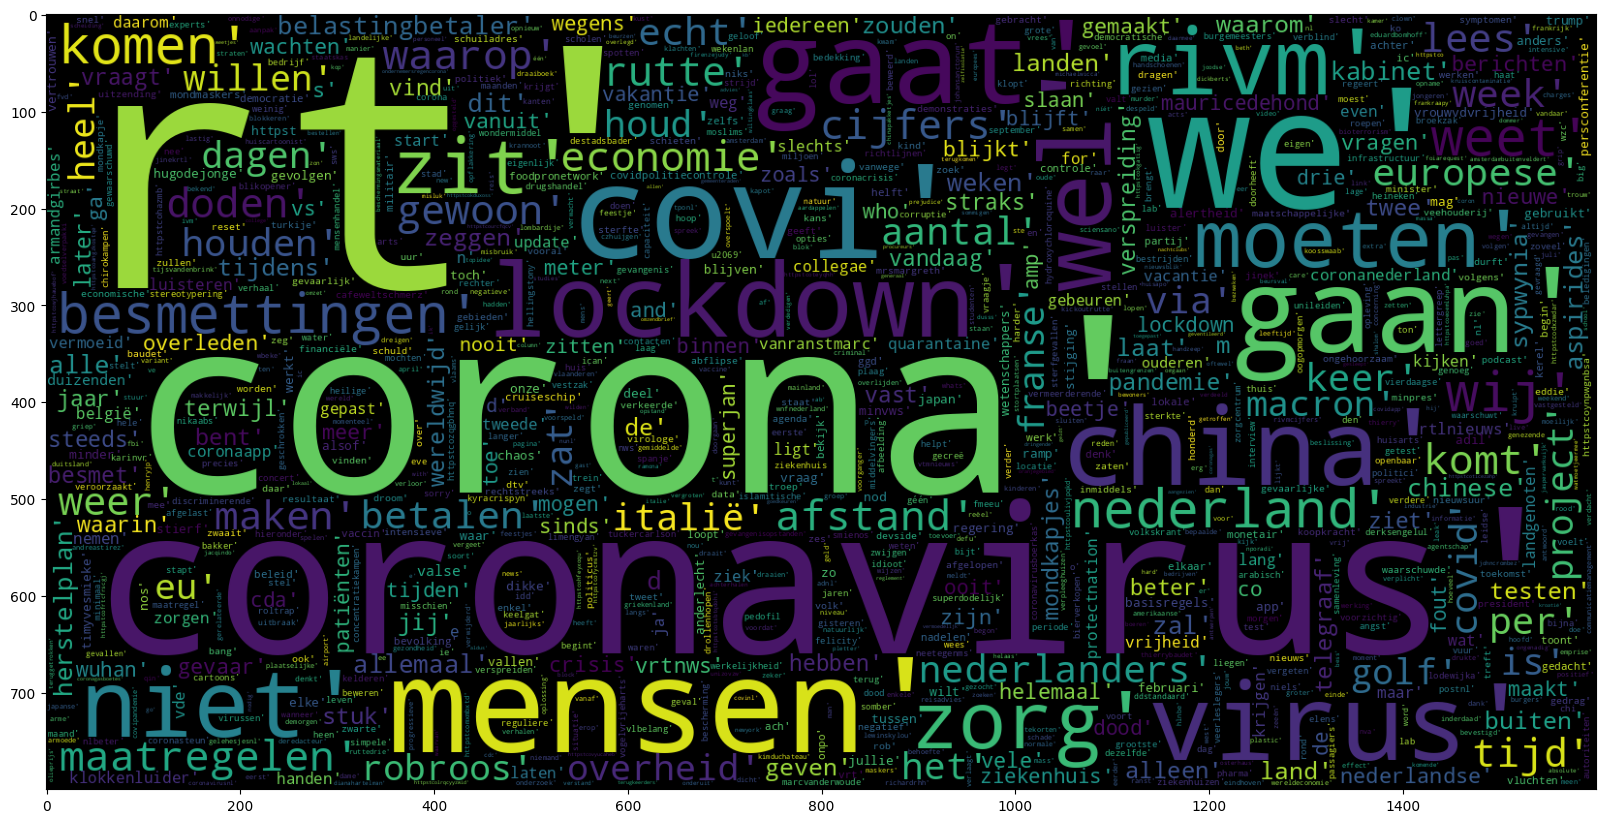

In [140]:
# Neg word cloud
# data_neg = data_neg[:9230]
plt.figure(figsize = (20,20))
wc_neg = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_neg)))
plt.imshow(wc_neg)


### Word cloud for positive words

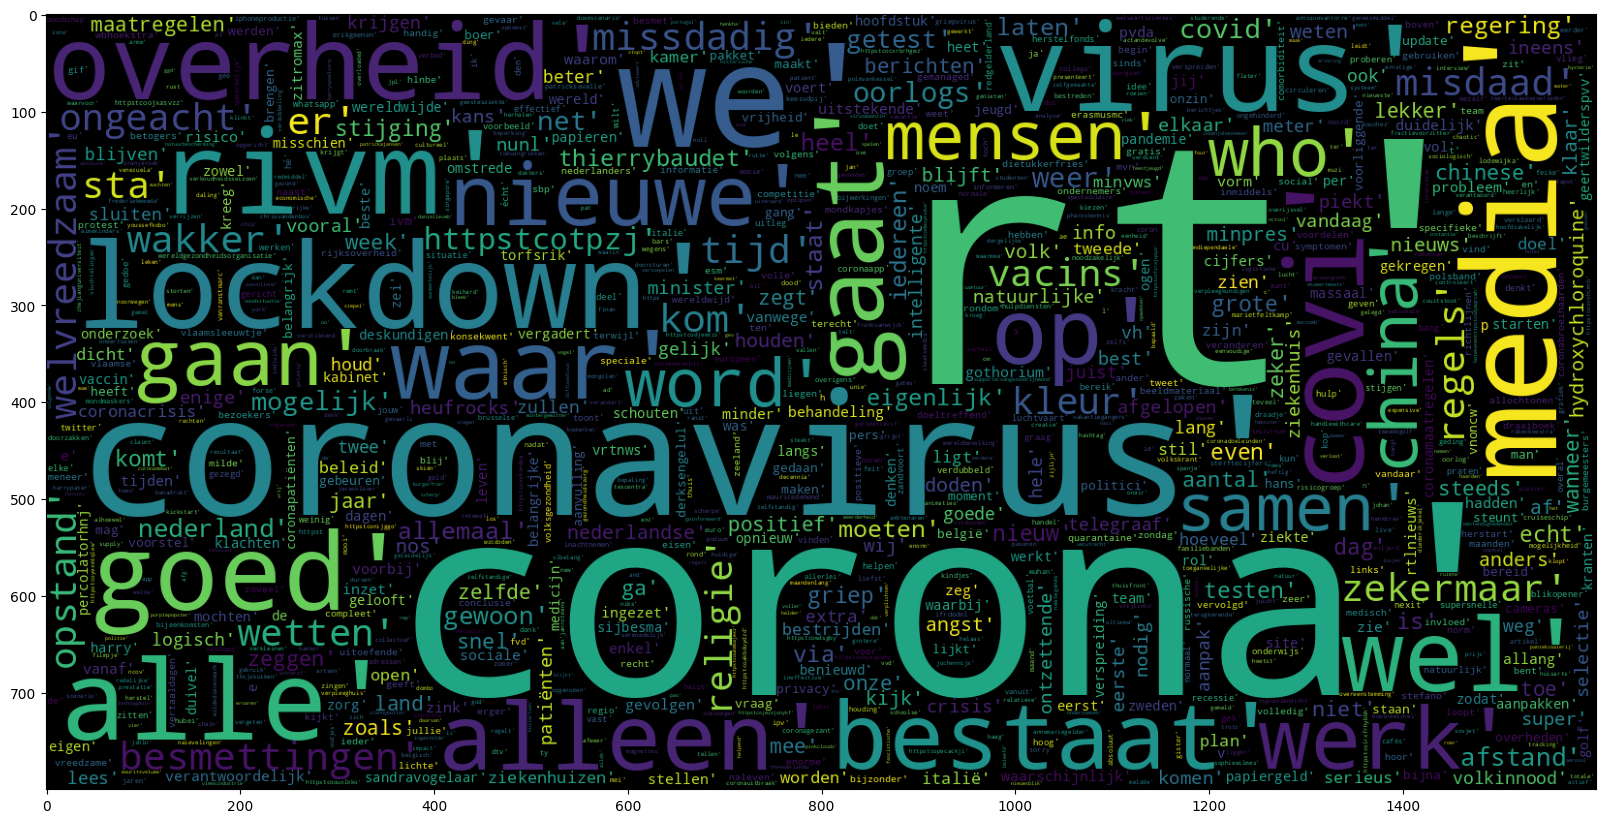

In [141]:
# pos wordcloud
# data_pos = data_pos[:17789]
plt.figure(figsize = (20,20))
wc_pos = WordCloud(max_words = 1000 , width = 1600 , height = 800,
               collocations=False).generate(" ".join(map(str, data_pos)))
plt.imshow(wc_pos)


## Modelling

## Prepare the data

In [142]:
# Split the data into train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.05, random_state = 42)

In [143]:
# Turn data into strings (ensures, otherwise may throw an error)
X_train = X_train.astype(str)
X_test = X_test.astype(str)

### Fit the TF-IDF Vectorizer

In [144]:
# Fit the tf-idf vectorizer on the training data (!)
vectoriser = TfidfVectorizer(ngram_range=(1, 2), max_features = 500000)
vectoriser.fit(X_train)

TfidfVectorizer(max_features=500000, ngram_range=(1, 2))

In [145]:
# Check how many feature words are extracted
print('No. of feature_words: ', len(vectoriser.get_feature_names_out()))

No. of feature_words:  13258


### Transform the data according to TF-IDF vectorizer

In [146]:
# Transform the data (both train and test data!) using the tf-idf vectorizer
X_train = vectoriser.transform(X_train)
X_test = vectoriser.transform(X_test)

### Model Evaluation

In [147]:
# Define a function for model evaluation
# creds to https://www.analyticsvidhya.com/blog/2021/06/twitter-sentiment-analysis-a-nlp-use-case-for-beginners/
def model_Evaluate(model):
    # Predict values for Test dataset
    y_pred = model.predict(X_test)
    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)
    categories = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]
    labels = [f'{v1}n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
    xticklabels = categories, yticklabels = categories)
    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values" , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

### Model 1: Train and evaluate a Bernoulli Naive Bayes model

              precision    recall  f1-score   support

         0.0       0.80      1.00      0.89        32
         1.0       1.00      0.71      0.83        28

    accuracy                           0.87        60
   macro avg       0.90      0.86      0.86        60
weighted avg       0.89      0.87      0.86        60



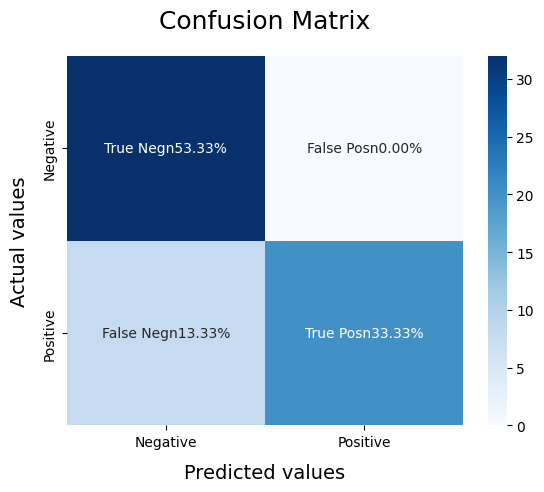

In [148]:
BNBmodel = BernoulliNB()
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)
y_pred1 = BNBmodel.predict(X_test)

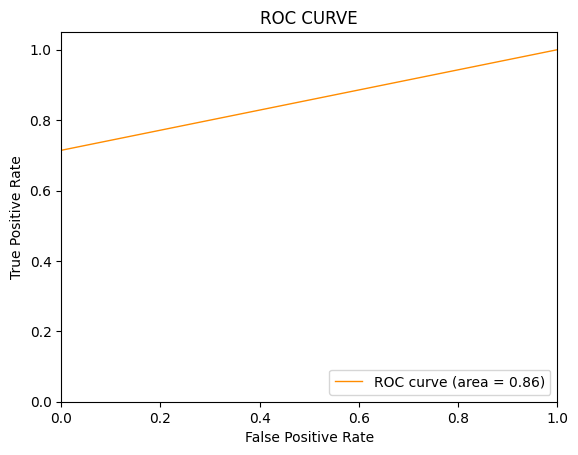

In [149]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred1)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 2: Train and evaluate a Linear Support Vector Classification model

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90        32
         1.0       0.96      0.79      0.86        28

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



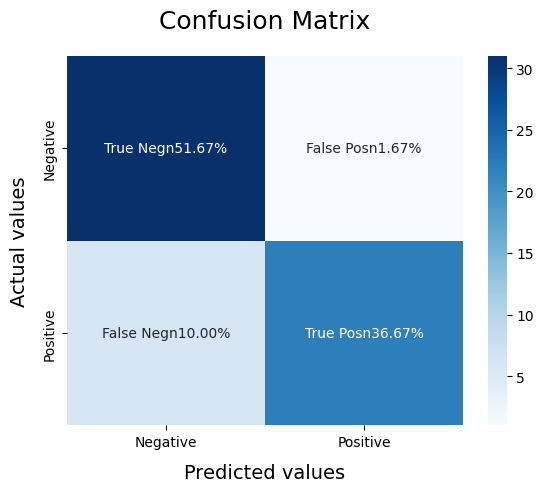

In [150]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
model_Evaluate(SVCmodel)
y_pred2 = SVCmodel.predict(X_test)

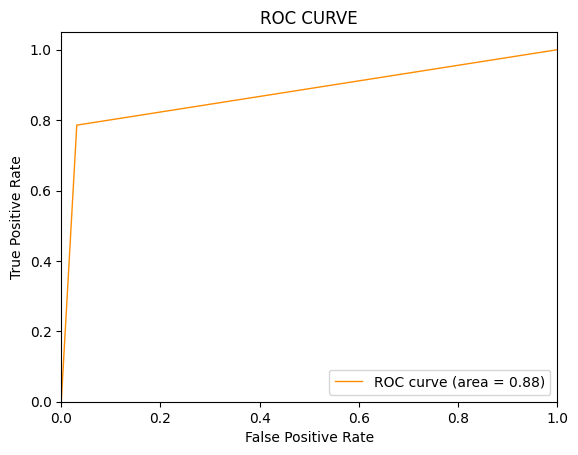

In [151]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Model 3: Train and evaluate a Logistic regression model

              precision    recall  f1-score   support

         0.0       0.84      0.97      0.90        32
         1.0       0.96      0.79      0.86        28

    accuracy                           0.88        60
   macro avg       0.90      0.88      0.88        60
weighted avg       0.89      0.88      0.88        60



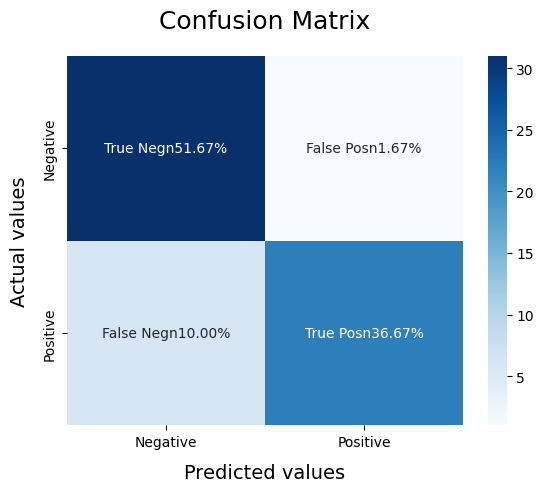

In [152]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)
y_pred3 = LRmodel.predict(X_test)

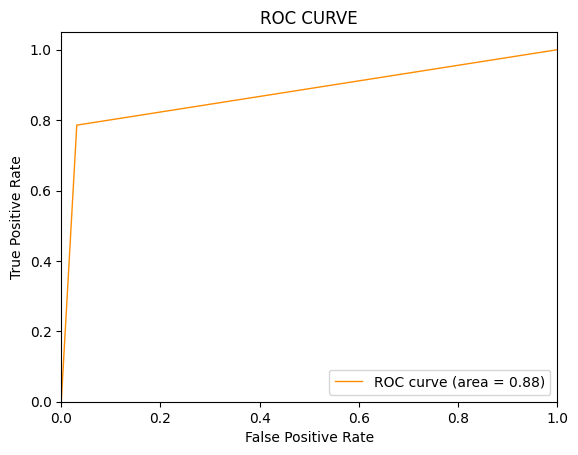

In [153]:
# Define a function for receiving a ROC curve and RUN it.
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred3)
roc_auc = auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC CURVE')
plt.legend(loc="lower right")
plt.show()

### Overall Interpretation:

In [154]:
# The linear support vector classifier (svc) worked the best